In [2]:
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr

### Input: pot. temp, moisture, height, and surface pessure

In [18]:
path="/lustre/ytzheng/"
Casename = 'ASTEX_cold2.6'

ff = xr.open_mfdataset(path + Casename + '/' +  '*N100.nc',
                      combine = 'by_coords',decode_cf = False)

#input
z = ff['z'].values
t0 = ff['THETA'].values[0]
q0 = ff['QV'].values[0]
pres_sfc = ff['Ps'].values[0]

D = 5e-6 #s-1
ztop = 1600 #m

nzm = len(z)

### The codes are based on original fortran code in SAM, so it is not very python-like

In [4]:
#generate empty arrays for holding 
presr = np.zeros(nzm)
presi = np.zeros(nzm)
pres = np.zeros(nzm)
tv0 = np.zeros(nzm)
prespot = np.zeros(nzm)
tabs0 = np.zeros(nzm)
zi = np.zeros(nzm)
rho = np.zeros(nzm)

In [5]:
#compute heights between original levels: zi
dz = np.diff(np.insert(z, 0, 0))
dz = 0.5*(dz + np.roll(dz, -1))
dz[0] = dz[0] + 0.5*z[0]
dz[nzm-1] = z[nzm-1]-z[nzm-2]

for k in range(1, nzm):
    zi[k] = zi[k-1] + dz[k-1]

In [6]:
#compute pressure
rgas = 287.
cp = 1005.
ggr = 9.81 
epsv = 0.61

presr[0]=(pres_sfc/1000.)**(rgas/cp)
presi[0]=pres_sfc

for k in range(0, nzm-1):
    q0[k]=q0[k]*1e-3
    tv0[k]=t0[k]*(1.+epsv*q0[k])
    presr[k+1]=presr[k]-ggr/cp/tv0[k]*(zi[k+1]-zi[k])
    presi[k+1]=1000.*presr[k+1]**(cp/rgas)
    pres[k] = np.exp(np.log(presi[k])+np.log(presi[k+1]/presi[k])*(z[k]-zi[k])/(zi[k+1]-zi[k]))
    prespot[k]=(1000./pres[k])**(rgas/cp)
    tabs0[k]=t0[k]/prespot[k]

for k in range(0, nzm-1):
     rho[k] = (presi[k]-presi[k+1])/(zi[k+1]-zi[k])/ggr*100.
        
pres[-1] = presi[-1]

In [9]:
#generate vertical velocity (m/s) and omega (Pa/s) 

w0 = np.zeros(nzm)
w0[z <=ztop] = -D*z[z <=ztop]
w0[z > ztop] = -D*ztop
omega0 = -w0*rho*ggr

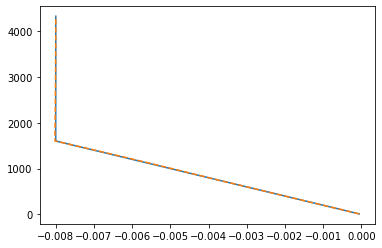

In [10]:
# check it works well
plt.plot(w0, z)
plt.plot(ff['WOBS'][0], z, linestyle = '--')

In [11]:
#concatenate atmosphere until pres = 0 pa
pres_conca = np.linspace(pres[-1], 0., 1000)
pres_full = np.concatenate((pres[:-2], pres_conca)) 

In [16]:
#Get the omega of the concatenated layer, which has no observations. 
#I just extroplolate the omega. This is not important since the top of 
#model domain is typically lower than the top of the observation

ind = np.where(z > ztop)[0]
coef_lin = np.polyfit(pres[ind], omega0[ind], 1)
omega0_conca = omega0[-2] + coef_lin[0]*(pres_conca - pres[-2])
omega0_full = np.concatenate((omega0[:-2], omega0_conca)) 

In [13]:
f  = xr.open_dataset('./astex_2010_v3a_SCAMIOP.nc')

(1027.7372919077436, 0.0)

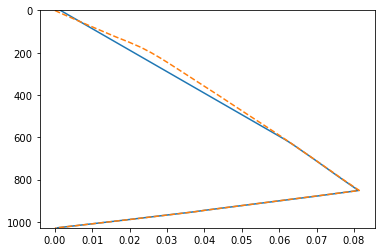

In [17]:
omega_ori = f['omega'].isel(tsec = 0).isel(lon = 0).isel(lat = 0)
pres_ori = f['lev']

plt.plot(omega0_full, pres_full)
plt.plot(omega_ori, pres_ori/100., linestyle = '--')
plt.ylim([pres_full[0], pres_full[-1]])

In [20]:
#make it as a function
def gen_omega(z, t, q, pres_sfc, D, ztop):
    #----Description of the function------
    # Input:
    # z: height (m)
    # t: potential temperature (K)
    # q: specific humidity (kg/kg)
    # pres_sfc: surface pressure (hPa)
    # D: divergence (s-1)
    # ztop: height above which the vertical velocity is a constant (m)
    
    #generate empty arrays for holding 
    nzm = len(z)
    presr = np.zeros(nzm)
    presi = np.zeros(nzm)
    pres = np.zeros(nzm)
    tv = np.zeros(nzm)
    zi = np.zeros(nzm)
    rho = np.zeros(nzm)
    
    #compute heights between original levels: zi
    dz = np.diff(np.insert(z, 0, 0))
    dz = 0.5*(dz + np.roll(dz, -1))
    dz[0] = dz[0] + 0.5*z[0]
    dz[nzm-1] = z[nzm-1]-z[nzm-2]

    for k in range(1, nzm):
        zi[k] = zi[k-1] + dz[k-1]
    
    #compute pressure
    rgas = 287.
    cp = 1005.
    ggr = 9.81 
    epsv = 0.61

    presr[0]=(pres_sfc/1000.)**(rgas/cp)
    presi[0]=pres_sfc

    for k in range(0, nzm-1):
        q[k]=q[k]*1e-3
        tv[k]=t[k]*(1.+epsv*q[k])
        presr[k+1]=presr[k]-ggr/cp/tv[k]*(zi[k+1]-zi[k])
        presi[k+1]=1000.*presr[k+1]**(cp/rgas)
        pres[k] = np.exp(np.log(presi[k])+np.log(presi[k+1]/presi[k])*(z[k]-zi[k])/(zi[k+1]-zi[k]))

    for k in range(0, nzm-1):
         rho[k] = (presi[k]-presi[k+1])/(zi[k+1]-zi[k])/ggr*100.

    pres[-1] = presi[-1]
    
    #generate vertical velocity (m/s) and omega (Pa/s) 
    w = np.zeros(nzm)
    w[z <=ztop] = -D*z[z <=ztop]
    w[z > ztop] = -D*ztop
    omega = -w*rho*ggr
    
    #concatenate atmosphere until pres = 0 pa
    pres_conca = np.linspace(pres[-1], 0., 1000)
    pres_full = np.concatenate((pres[:-2], pres_conca)) 
    
    #Get the omega of the concatenated layer, which has no observations. 
    #I just extroplolate the omega. This is not important since the top of 
    #model domain is typically lower than the top of the observation
    ind = np.where(z > ztop)[0]
    coef_lin = np.polyfit(pres[ind], omega[ind], 1)
    omega_conca = omega[-2] + coef_lin[0]*(pres_conca - pres[-2])
    omega_full = np.concatenate((omega[:-2], omega_conca)) 
    
    #add pres coordinate to omega to make it a dataArray type
    omega_out = xr.DataArray(omega_full,
                            dims = "lev",
                            coords = {"lev": pres_full})
    
    return omega_out

In [58]:
#test the result
z = ff['z'].values
t = ff['THETA'].values[0]
q = ff['QV'].values[0]
pres_sfc = ff['Ps'].values[0]

D = 5e-6 #s-1
ztop = 1600 #m

omega_out = gen_omega(z, t, q, pres_sfc, D, ztop)

In [85]:
f=open('./ASTEX_input_height.txt',"r")
lines=f.readlines()
z=[]
t=[]
q=[]
for x in lines:
    z.append(x.split()[1])
    t.append(x.split()[6])
    q.append(x.split()[8])
f.close()

z = np.flip(np.array(z[1:]).astype(np.float))
t = np.flip(np.array(t[1:]).astype(np.float))
q = np.flip(np.array(q[1:]).astype(np.float))/1000.

pres_sfc = 1029.0

D = 5e-6 #s-1
ztop = 1600 #m

omega_out = gen_omega(z, t, q, pres_sfc, D, ztop)

(1027.7372919077436, 0.0)

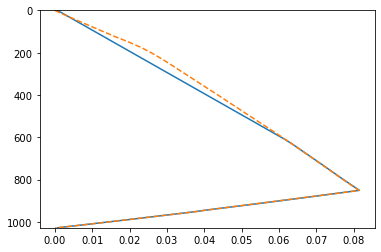

In [87]:
plt.plot(omega_out, omega_out.coords['lev'])
plt.plot(omega_ori, pres_ori/100., linestyle = '--')
plt.ylim([pres_full[0], pres_full[-1]])